In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import dual_annealing
from scipy.optimize import least_squares

In [2]:
'''
March 24, 2019:
Can I adapt the code for the coupled harmonic oscillators
into a code for coupled van-der-pol oscillators?

Also, what do coupled van-der-pol oscillators look like, when animated?
'''

'\nMarch 24, 2019:\nCan I adapt the code for the coupled harmonic oscillators\ninto a code for coupled van-der-pol oscillators?\n\nAlso, what do coupled van-der-pol oscillators look like, when animated?\n'

In [3]:
'''
Code for the coupled harmonic oscillators...
'''

'\nCode for the coupled harmonic oscillators...\n'

In [4]:

# Adapting coupled springs.
# From personal notebook, March 24

N = 5 # number of masses (may accidentally call this the number of springs)

''' Changed the value of d so the oscillators do not move past each other.'''
d = 6. # distance between rest positions (uniform)
k = np.pi # spring const

# generalize to allow different spring constants on different springs..
K = np.ones(N) * k

x0 = 0. # LHS resting board is at position x0

# set rest positions of springs + boards
R = np.arange(0, d *(N + 1 + 1), d, dtype=np.float_)

# set initial positions of springs
X = np.copy(R)
X[1] -= 0.8 
X[2] -= 0.4

DX = X - R

''' Think that my acceleration formula changes quite a bit '''
MU = np.ones(N)
F_accel = lambda DX, XV: -K * (DX[1:-1] - DX[:-2]) + K * (DX[2:] - DX[1:-1]) + MU * (1 - np.power(DX[1:-1], 2)) * XV[N:]

# old formula (springs)
#F_accel = lambda DX: -K * (DX[1:-1] - DX[:-2]) + K * (DX[2:] - DX[1:-1])



DX

# old.
# F_accel(DX) # looks okay.

array([ 0. , -0.8, -0.4,  0. ,  0. ,  0. ,  0. ])

In [5]:
# Set up the linear system.
XV = np.zeros(2 * N)

# Initial conditions?
XV[:N] = X[1:-1] # Initial positions of the springs
XV[N:] = np.zeros(N) # initial velocities of the springs

In [6]:
''' Try calling the new formula for the acceleration. '''
F_accel(DX, XV) # Ok, looks good.

array([ 3.76991118e+00,  2.88657986e-15, -1.25663706e+00,  0.00000000e+00,
        0.00000000e+00])

In [7]:
# Although this is an autonomous system
''' This should mostly be the same though? '''
def F(t, XV):
    
    DX = np.hstack( ([0.], XV[:N], [X[-1]]) ) - R # ''' Changed the last arg in the list to hopefully unbreak the case when d neq 1.'''
    
    res = np.hstack(( XV[N:], F_accel(DX, XV) ) # '''Changed the args to F_accel.'''
                    )
    return res

F(0, XV)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.76991118e+00,  2.88657986e-15, -1.25663706e+00,
        0.00000000e+00,  0.00000000e+00])

In [8]:
t0, tf = 0., 30.
nframes = 2 ** 12

# set the initial condition...
IC = XV

soln = solve_ivp(F, [t0, tf], IC,
                t_eval=np.linspace(t0,tf,nframes))

'''
Hey, it looks like I was able to modify the code with no syntax errors! Let's see how the solution behaves...

'''

"\nHey, it looks like I was able to modify the code with no syntax errors! Let's see how the solution behaves...\n\n"

7.5363936170289065


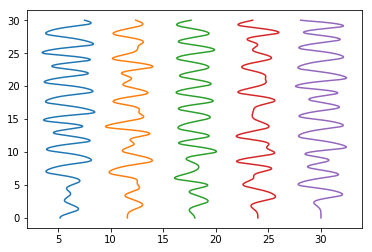

In [10]:
# April 3: Add snippet.

# plot the positions of the springs....

for i in range(N):
    plt.plot(soln.y[i,:], soln.t)
    
print(soln.y[0, -1])

2.2.2
writing to GIF


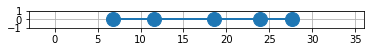

In [21]:
ntimesteps = soln.t.shape[-1] # if all blocks are solved with same ntimesteps

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True, xlim=(-d / 2, d * (N + 1)), ylim=(-1,1)) # modified xlim for other d.
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2, markersize=14)

import matplotlib.animation as animation

def init():
    line.set_data([], [])
    return line,


NN = 2 ** 4 # display only every NN frames
def animate(i):
    line.set_data(soln.y[:N,i * NN].reshape(N,) ,np.zeros(N))
    return line,

ani = animation.FuncAnimation(fig, animate, ntimesteps // NN,
                            interval=10, repeat=True,
                            blit=True, init_func=init)
import matplotlib
print(matplotlib.__version__)

print('writing to GIF')
ani.save('vdp_springs.gif', writer='imagemagick')
print('..done.')

print('rendering HTML')
from IPython.display import HTML
HTML(ani.to_html5_video())
print('..done.')

In [15]:
'''
Code for adding noise to a single harmonic oscillator...
'''

'\nCode for adding noise to a single harmonic oscillator...\n'

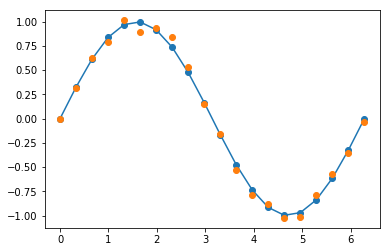

In [2]:
# How well does simulated annealing fit the spring constant for a simple harmonic oscillator?
# Adapted from material from March 24, 2019.

# Simplest possible test case..
# We know that for k=1, a single spring satisfies the equation
# y'' = -y
# which solves to sin(t) given an initial condition [0, 1]
# so why don't we use the curve y(t) = sin(t) as our 'data - to - fit' curve?

# will we also have to fit the initial condition?
# this gives us three parameters to estimate...
# Well, why don't we say that the initial condition can be fit pretty well
# because of our lab measurement.

T = np.linspace(0, np.pi * 2, 20) # number of datapoints is N
Y = np.sin(T)

absolute_noise_limit = 0.05

percent_noise = 0.05
relative_noise_limit = percent_noise * Y 

# remember: multiplying by noise changes the stddev.
noise = np.random.randn(Y.shape[0]) * absolute_noise_limit

noisy_data = Y + np.hstack(([0], noise[1:]))

plt.plot(T, Y, 'o-')
plt.plot(T, noisy_data, 'o')


In [3]:
'''
# Sample code from the doc on least_squares.

y_train = gen_data(t_train, a, b, c, noise=0.1, n_outliers=3)

def fun(x, t, y):
    return x[0] + x[1] * np.exp(x[2] * t) - y

x0 = np.array([1.0, 1.0, 0.0])

res_lsq = least_squares(fun, x0, args=(t_train, y_train))

'''

k_guess = 1.17
IC = [k_guess]



def solve_harmonic_oscillator(params, T, Y):
    k = params[0]
    F = lambda t, x: [x[1], 
                  - k * x[0]]
    IC = Y[0], 1. # pretend we also have an exact velocity reading
    soln = solve_ivp(F, [T[0], T[-1]], IC,
                t_eval=T)
    
    return soln.y[0,:] - Y

In [4]:
%%time

res_lsq = least_squares(solve_harmonic_oscillator, IC, args=(T, noisy_data))

k_found = res_lsq.x

print(k_found)
print(f'N function evals: {res_lsq.nfev}')

[0.9966897]
N function evals: 5
CPU times: user 41.3 ms, sys: 49.7 ms, total: 91 ms
Wall time: 43.5 ms


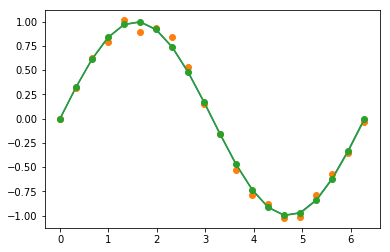

In [5]:
F = lambda t, x: [x[1], 
                  - k_found * x[0]]

IC = [0., 1.]
soln = solve_ivp(F, [T[0], T[-1]], IC,
            t_eval=T)

plt.plot(T, Y, '-')
plt.plot(T, noisy_data, 'o')
plt.plot(soln.t, soln.y[0,:],'o-') # hey, this is a great fit!

In [6]:
# same as above, but normed last line.

def solve_harmonic_oscillator(params):
    global T
    Y = noisy_data
    
    k = params[0]
    F = lambda t, x: [x[1], 
                  - k * x[0]]
    IC = Y[0], 1. # pretend we also have an exact velocity reading
    soln = solve_ivp(F, [T[0], T[-1]], IC,
                t_eval=T)
    
    return np.sum((soln.y[0,:] - Y) ** 2)

In [8]:
%%time

ret = dual_annealing(solve_harmonic_oscillator, list(zip([0], [3])),
                    maxiter=5)

print(ret.nfev)

# weird... for this question, dual annealing seems to actually do very well for even a low number of iterations.

print(ret)


27
     fun: 0.04350712633561511
 message: ['Maximum number of iteration reached']
    nfev: 27
    nhev: 0
     nit: 5
    njev: 0
       x: array([0.99668966])
CPU times: user 56.7 ms, sys: 1.35 ms, total: 58 ms
Wall time: 60.4 ms


In [ ]:
'''
Okay, probably time to move onto
the next part of this project.

'''